# EMNIST DataSet Project

**Mohammad Mazrouei** \
**4003613056** 

# Imports

In [139]:
import torch
import torchvision
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt

# Data Preparation 

**Transformations**  
Compose is used to combine multiple transformations into one.  
ToTensor() converts a PIL image or NumPy ndarray to a tensor.  
lambda reshapes the tensor into a 1D tensor with 784 elements (28x28 = 784), which is the flattened version of the MNIST images.  

**Load Dataset**  
The MNIST class is used to download and load the MNIST dataset, applying the transformations to each image in the dataset. 

**Validation Data**  
Validation data is a subset of your dataset that is used to evaluate the performance of a model during training.  
Purpose of Validation Data: Model Evaluation, Hyperparameter Tuning, Early Stopping, Model Selection.

**Show Data**  
show_image(tensor) function reshapes the flattened tensor back to 28x28 and displays it using plt.imshow.  

In [140]:
transform = Compose([
    ToTensor(),
    Lambda(lambda image: image.view(784))
])

data_train = MNIST(root="./", download=True, train=True, transform=transform)
data_test = MNIST(root="./", download=True, train=False, transform=transform)

In [141]:
VALIDATION_SPLIT = 0.1
train_size = int((1 - VALIDATION_SPLIT) * len(data_train))
val_size = len(data_train) - train_size

data_train, data_val = random_split(data_train, [train_size, val_size])

In [142]:
print(f'#NO train data: {len(data_train)}')
print(f'#NO test data:  {len(data_test)}')
print(f'#NO validation data: {len(data_val)}')

#NO train data: 54000
#NO test data:  10000
#NO validation data: 6000


In [143]:
data_train[0][0].shape

torch.Size([784])

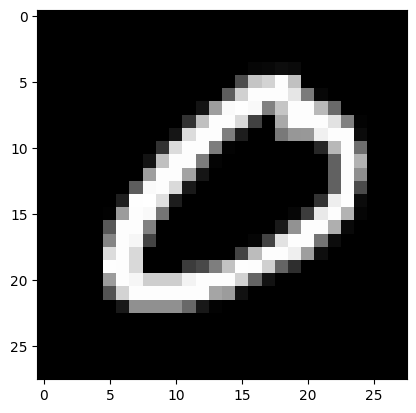

0


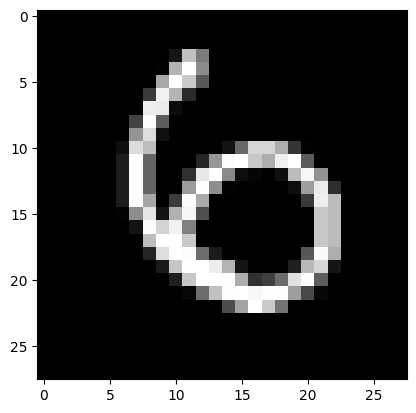

6


In [144]:
def show_image(tensor):
    # Reshape the tensor back to 28x28
    image = tensor.view(28, 28)
    plt.imshow(image, cmap='gray')
    plt.show()

sample_image, label = data_train[0]
show_image(sample_image)
print(label)

sample_image, label = data_train[1]
show_image(sample_image)
print(label)

# Functions

**get_default_device:** This function checks if a GPU (CUDA) is available and returns the corresponding device.  
**to_t:** This function transfers a given tensor to the specified device.

In [120]:
def get_default_device():
    return torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def to_t(tensor, device=get_default_device()):
    return tensor.to(device)

**train_the_model:** train model and Returns the list of average training and validation losses for all epochs.  

In [121]:
def train_the_model(mnist_model):
    train_losses = []
    val_losses = []
    
    for epoch in range(EPOCHS):
        mnist_model.train() 
        
        total_train_loss = 0
        for r_xs, r_ys in dataloader_train:
            xs, ys = to_t(r_xs), to_t(r_ys)
            total_train_loss += mnist_model.fit(xs, ys)
        total_train_loss /= len(dataloader_train)
        train_losses.append(total_train_loss)
        
        # Calculate validation loss
        mnist_model.eval()  
        total_val_loss = 0
        with torch.no_grad(): 
            for r_xs, r_ys in dataloader_val:
                xs, ys = to_t(r_xs), to_t(r_ys)
                y_pred = mnist_model.forward(xs)
                total_val_loss += mnist_model.loss(y_pred, ys).item()
        total_val_loss /= len(dataloader_val)
        val_losses.append(total_val_loss)
        
        print(f"EPOCH {epoch + 1}: Train Loss = {total_train_loss:.4f}, Validation Loss = {total_val_loss:.4f}")
    
    return train_losses, val_losses

**plot_loss_curve:** plots the training and validation loss curves over epochs.

In [122]:
def plot_loss_curve(train_loss, val_loss):
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

**evaluate_model:** evaluates the accuracy of the model on the test dataset by comparing the predicted labels to the true labels and counting the number of correct predictions.

In [152]:
def evaluate_model(model):
    correct = 0
    for r_xs, r_ys in dataloader_test:
        xs, ys = to_t(r_xs), to_t(r_ys)
        y_pred = model.predict(xs)
        correct += (ys == y_pred).sum()
    acc = correct / (len(dataloader_test) * BATCH_SIZE)
    print(f'ACCURACY: {acc:.6f}')
    return acc

**create_bar_chart:** creates a bar chart comparing the accuracies of different models, highlighting the model with the highest accuracy in red.

In [153]:
def create_bar_chart(model_names, model_accuracies):
    max_accuracy = max(model_accuracies)
    bars = []
    for i, acc in enumerate(model_accuracies):
        if acc == max_accuracy:
            bars.append(plt.bar(model_names[i], acc, color='red', edgecolor='black', linewidth=1.5))
        else:
            bars.append(plt.bar(model_names[i], acc, color='skyblue', edgecolor='black', linewidth=1.5))
            
    plt.xlabel('Model Name', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.title('Comparison of Model Accuracies', fontsize=16, weight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Loss & Cross entropy loss

## Loss

Loss, also known as the loss function or cost function, is a measure of how well a machine learning model's predictions match the true labels. It quantifies the difference between the predicted values and the actual values. The goal of training a model is to minimize this loss, thereby improving the accuracy of the model's predictions.

## Cross entropy loss

Cross-Entropy Loss, often used in classification tasks, measures the difference between two probability distributions - the predicted probability distribution and the true distribution (labels). It quantifies how well the predicted probabilities match the actual class labels.

$$ \text{Loss} = -\sum_{i=1}^{C} y_i \log(p_i) $$  
- \( C \) is the number of classes.  
- \( y_i \) is the true label (1 if the instance belongs to class \( i \), 0 otherwise).  
- \( p_i \) is the predicted probability of the instance belonging to class \( i \).  

# Architecture (layer and neurons)

## Explain Model

**init Method**  
*Parameters:*  
input_size=784: Number of input features (default is 784 for flattened 28x28 MNIST images).  
hidden_layers=[512]: List specifying the number of neurons in each hidden layer.  
output_size=10: Number of output features (default is 10 for the MNIST classification task).  

*Sequential Layers:*  
self.layers = nn.Sequential(*layers): Combines all the layers into a sequential container.  

*Loss Function:*  
self.loss = nn.CrossEntropyLoss(): Defines the cross-entropy loss function, suitable for classification.  

*Optimizer:*  
self.optimizer = optim.Adam(self.parameters()): Defines the Adam optimizer to update model parameters during training.  

*Device Transfer:*  
self.to(get_default_device()): Moves the model to the appropriate device (CPU or GPU).  

**forward Method**  
Takes input X and passes it through the defined layers.  
Returns the output of the final layer.  

**predict Method**  
Disables gradient calculation using torch.no_grad() for prediction to save memory and computation.  
Passes the input X through the model to get the output logits.  
Uses torch.argmax to get the index of the highest logit, which corresponds to the predicted class.  

**fit Method**  
*Zero Gradients:*  
self.optimizer.zero_grad(): Clears the gradients of all optimized tensors.  
*Forward Pass:*  
y_pred = self.forward(X): Computes the forward pass to get the predicted output.  
*Compute Loss:*  
loss = self.loss(y_pred, Y): Calculates the loss between the predicted output y_pred and the true labels Y.  
*Backward Pass:*  
loss.backward(): Backpropagates the error to compute gradients.  
*Optimizer Step:*  
self.optimizer.step(): Updates the model parameters based on the gradients.  
*Return Loss:*  
return loss.item(): Returns the scalar value of the loss for monitoring training progress.  

In [125]:
class Model(nn.Module):
    def __init__(self, input_size=784, hidden_layers=[512], output_size=10):
        super().__init__()
        layers = []
        in_features = input_size
        for hidden_units in hidden_layers:
            layers.append(nn.Linear(in_features, hidden_units))
            layers.append(nn.ReLU())
            in_features = hidden_units
        layers.append(nn.Linear(in_features, output_size))
        self.layers = nn.Sequential(*layers)
        
        self.loss = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters())
        self.to(get_default_device())
        
    def forward(self,X):
        return self.layers(X)

    def predict(self,X):
        with torch.no_grad():
            return torch.argmax(self.forward(X), axis=-1)
            
    def fit(self,X,Y):
        self.optimizer.zero_grad()
        y_pred = self.forward(X)
        loss = self.loss(y_pred, Y)
        loss.backward()
        self.optimizer.step()
        return loss.item()

## How to adjust the number of layers and the number of neurons in each layer?

To calculate the best value for the number of layers and neurons inside each layer,  
we first consider the rest of the parameters constant and run the model for different layer and neurons values.  

**Effect of Number of Layers and Neurons**  
*Underfitting:*  
Model1 and Model2: These models underfit due to insufficient neurons. They are too simple to capture the complexities of the data.  
Indicators: High training loss values and slow improvement across epochs.  

*Balanced Fit:*  
Model3 and Model4: These models balance capacity and performance well. They have enough neurons to learn the data without being too complex.  
Indicators: Rapid decrease in loss values and lower final loss.  

*Overfitting:*  
Model5, Model6, Model7, Model8: These models show signs of overfitting within 5 epochs.  
Indicators: constant or increase validation loss values in epochs.  

**Best Model**  
Model4 (hidden_layers = [512]) the best model considering the following factors:  
Performance: It achieves low loss values early in training, comparable to larger models.  
Simplicity: It maintains simplicity with a single hidden layer, reducing the risk of overfitting and computational cost.  

In [126]:
model_names = []
model_accuracies = []

**BATCH_SIZE:** The number of samples processed before the model is updated.  
**EPOCHS:** The number of complete passes through the training dataset.  
**dataloader_train:** Loads the training dataset in batches of size BATCH_SIZE and shuffles the data.  
**dataloader_test:** Loads the test dataset in batches of size BATCH_SIZE and shuffles the data.  
**dataloader_val:** Loads the validation dataset in batches of size BATCH_SIZE and shuffles the data.  

In [127]:
BATCH_SIZE = 16
EPOCHS = 5
dataloader_train = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True)
dataloader_test = DataLoader(data_test, batch_size=BATCH_SIZE, shuffle=True)
dataloader_val = DataLoader(data_val, batch_size=BATCH_SIZE, shuffle=True)

EPOCH 1: Train Loss = 1.9560, Validation Loss = 1.8004
EPOCH 2: Train Loss = 1.7268, Validation Loss = 1.6834
EPOCH 3: Train Loss = 1.6597, Validation Loss = 1.6500
EPOCH 4: Train Loss = 1.6349, Validation Loss = 1.6349
EPOCH 5: Train Loss = 1.6212, Validation Loss = 1.6225
ACCURACY: 0.313000


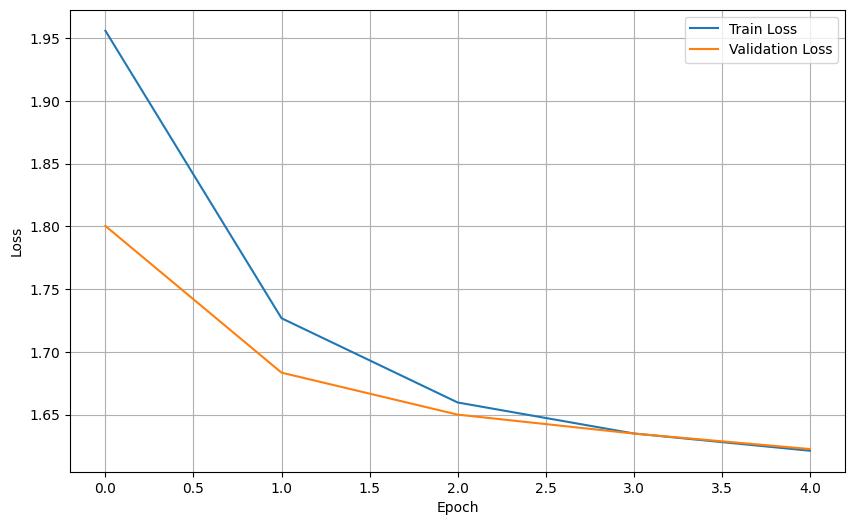

In [128]:
model1 = Model(hidden_layers = [2])
training_loss_model1, val_loss_model1 = train_the_model(model1)
acc_model1 = evaluate_model(model1)

model_names.append('model1')
model_accuracies.append(acc_model1)
plot_loss_curve(training_loss_model1, val_loss_model1)

EPOCH 1: Train Loss = 0.5923, Validation Loss = 0.3911
EPOCH 2: Train Loss = 0.3297, Validation Loss = 0.3237
EPOCH 3: Train Loss = 0.2954, Validation Loss = 0.3154
EPOCH 4: Train Loss = 0.2791, Validation Loss = 0.3034
EPOCH 5: Train Loss = 0.2689, Validation Loss = 0.3018
ACCURACY: 0.922100


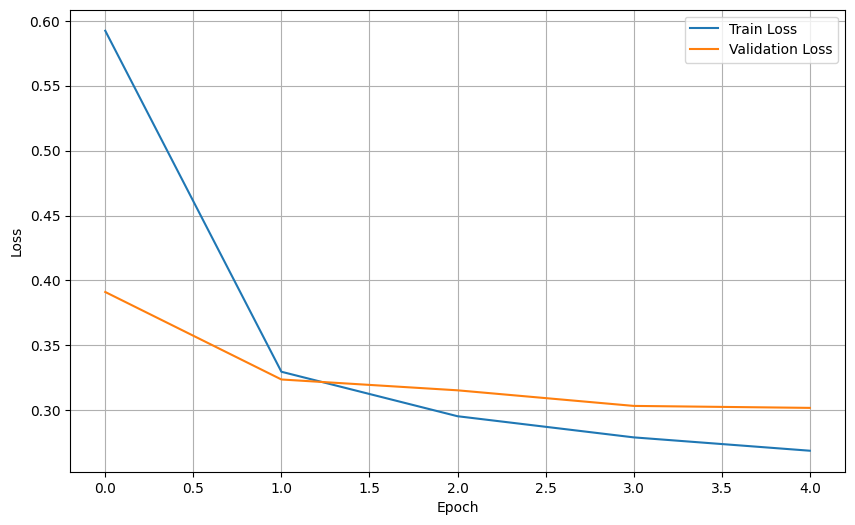

In [130]:
model2 = Model(hidden_layers = [8])
training_loss_model2, val_loss_model2 = train_the_model(model2)
acc_model2 = evaluate_model(model2)

model_names.append('model2')
model_accuracies.append(acc_model2)
plot_loss_curve(training_loss_model2, val_loss_model2)

EPOCH 1: Train Loss = 0.2361, Validation Loss = 0.1286
EPOCH 2: Train Loss = 0.0975, Validation Loss = 0.1098
EPOCH 3: Train Loss = 0.0643, Validation Loss = 0.0808
EPOCH 4: Train Loss = 0.0473, Validation Loss = 0.0787
EPOCH 5: Train Loss = 0.0357, Validation Loss = 0.0789
ACCURACY: 0.978600


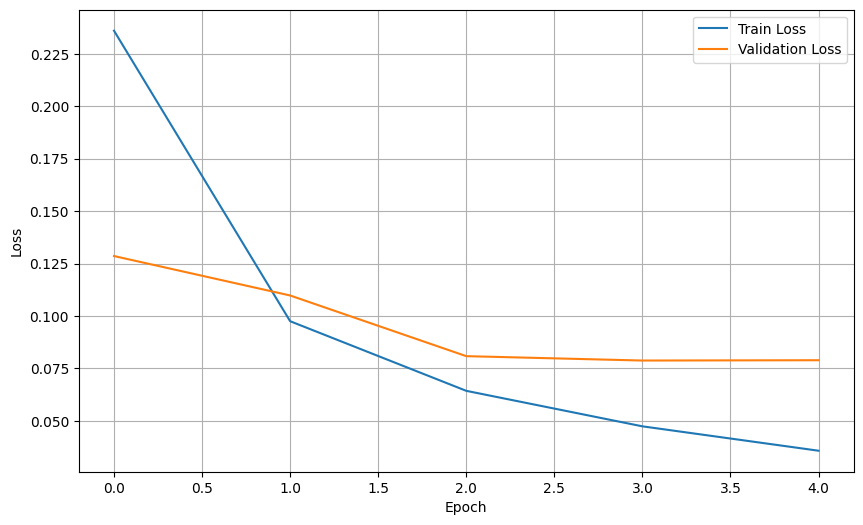

In [131]:
model3 = Model(hidden_layers = [256])
training_loss_model3, val_loss_model3 = train_the_model(model3)
acc_model3 = evaluate_model(model3)

model_names.append('model3')
model_accuracies.append(acc_model3)
plot_loss_curve(training_loss_model3, val_loss_model3)

EPOCH 1: Train Loss = 0.2074, Validation Loss = 0.1233
EPOCH 2: Train Loss = 0.0842, Validation Loss = 0.0838
EPOCH 3: Train Loss = 0.0555, Validation Loss = 0.0881
EPOCH 4: Train Loss = 0.0403, Validation Loss = 0.0774
EPOCH 5: Train Loss = 0.0301, Validation Loss = 0.0801
ACCURACY: 0.981300


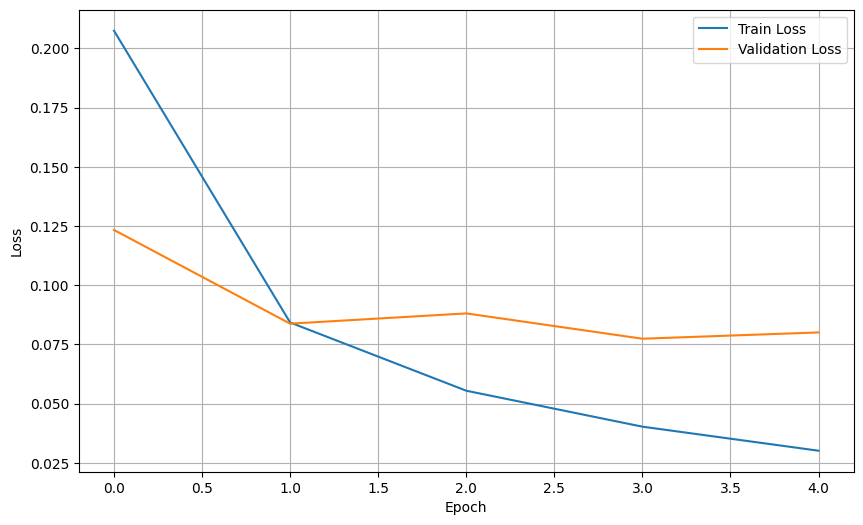

In [132]:
model4 = Model(hidden_layers = [512])
training_loss_model4, val_loss_model4 = train_the_model(model4)
acc_model4 = evaluate_model(model4)

model_names.append('model4')
model_accuracies.append(acc_model4)
plot_loss_curve(training_loss_model4, val_loss_model4)

EPOCH 1: Train Loss = 0.1915, Validation Loss = 0.1007
EPOCH 2: Train Loss = 0.0784, Validation Loss = 0.0846
EPOCH 3: Train Loss = 0.0507, Validation Loss = 0.0915
EPOCH 4: Train Loss = 0.0387, Validation Loss = 0.0874
EPOCH 5: Train Loss = 0.0299, Validation Loss = 0.0868
ACCURACY: 0.981300


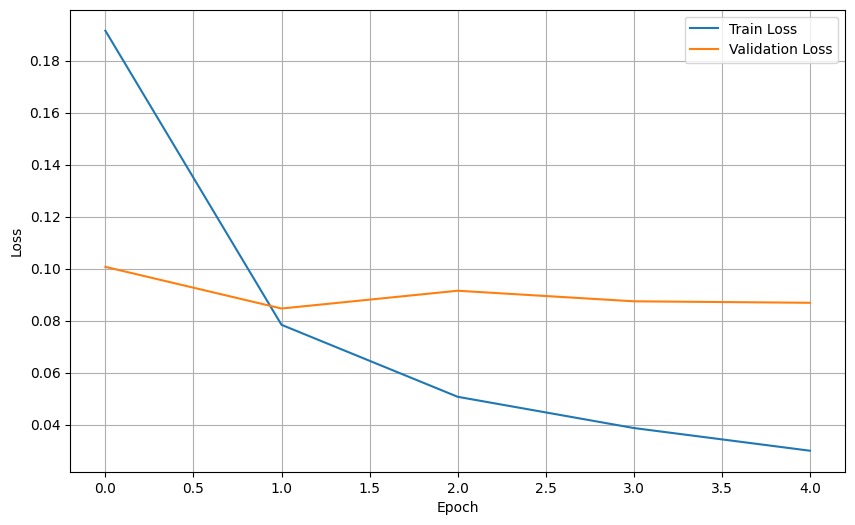

In [133]:
model5 = Model(hidden_layers = [1024])
training_loss_model5, val_loss_model5 = train_the_model(model5)
acc_model5 = evaluate_model(model5)

model_names.append('model5')
model_accuracies.append(acc_model5)
plot_loss_curve(training_loss_model5, val_loss_model5)

EPOCH 1: Train Loss = 0.2042, Validation Loss = 0.1065
EPOCH 2: Train Loss = 0.0909, Validation Loss = 0.0984
EPOCH 3: Train Loss = 0.0639, Validation Loss = 0.1132
EPOCH 4: Train Loss = 0.0522, Validation Loss = 0.0831
EPOCH 5: Train Loss = 0.0395, Validation Loss = 0.1081
ACCURACY: 0.979900


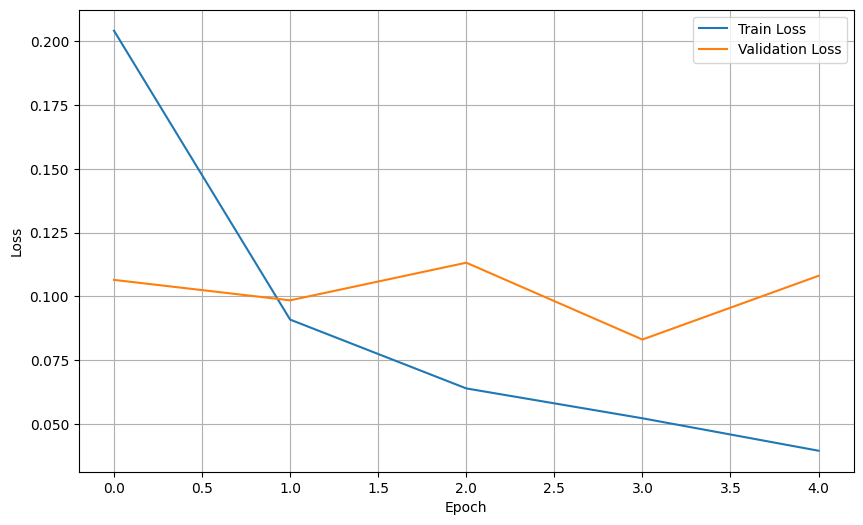

In [134]:
model6 = Model(hidden_layers = [512, 512])
training_loss_model6, val_loss_model6 = train_the_model(model6)
acc_model6 = evaluate_model(model6)

model_names.append('model6')
model_accuracies.append(acc_model6)
plot_loss_curve(training_loss_model6, val_loss_model6)

EPOCH 1: Train Loss = 0.2278, Validation Loss = 0.1525
EPOCH 2: Train Loss = 0.1060, Validation Loss = 0.1169
EPOCH 3: Train Loss = 0.0785, Validation Loss = 0.1172
EPOCH 4: Train Loss = 0.0621, Validation Loss = 0.0802
EPOCH 5: Train Loss = 0.0501, Validation Loss = 0.1335
ACCURACY: 0.969900


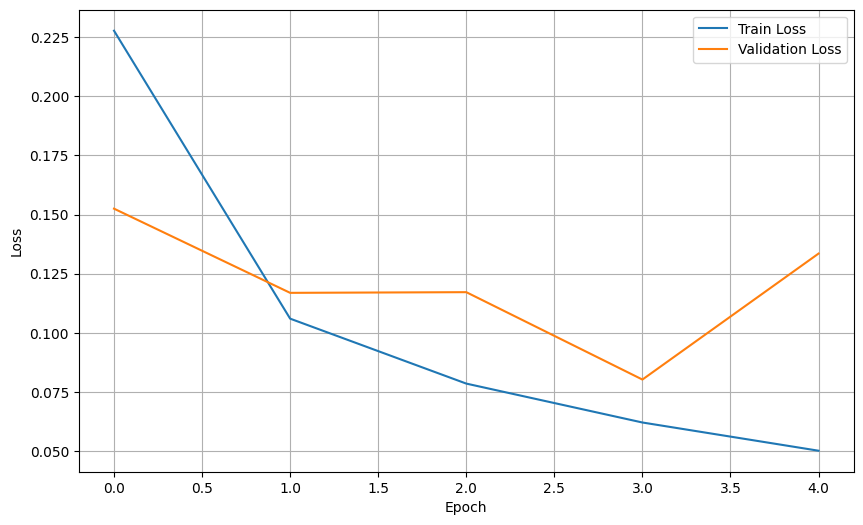

In [135]:
model7 = Model(hidden_layers = [512, 256, 512])
training_loss_model7, val_loss_model7 = train_the_model(model7)
acc_model7 = evaluate_model(model7)

model_names.append('model7')
model_accuracies.append(acc_model7)
plot_loss_curve(training_loss_model7, val_loss_model7)

EPOCH 1: Train Loss = 0.2551, Validation Loss = 0.1727
EPOCH 2: Train Loss = 0.1201, Validation Loss = 0.1077
EPOCH 3: Train Loss = 0.0864, Validation Loss = 0.0993
EPOCH 4: Train Loss = 0.0695, Validation Loss = 0.0942
EPOCH 5: Train Loss = 0.0573, Validation Loss = 0.1032
ACCURACY: 0.978800


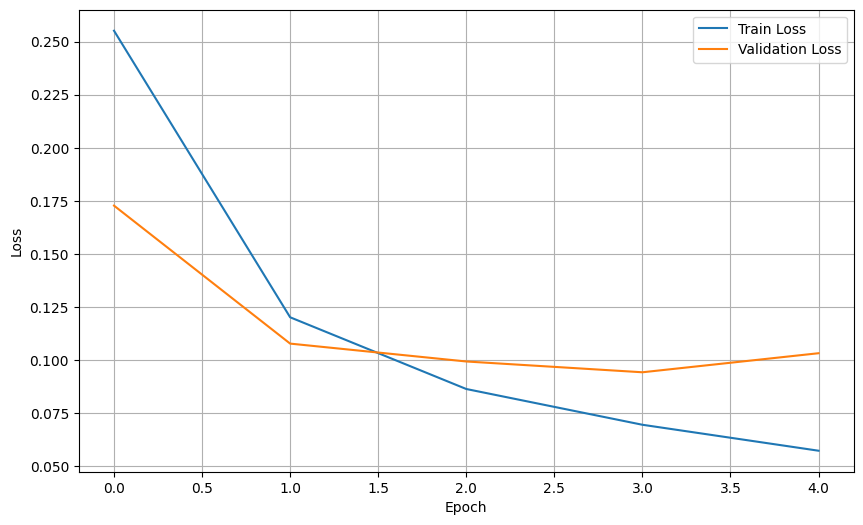

In [136]:
model8 = Model(hidden_layers = [512, 256, 256, 512])
training_loss_model8, val_loss_model8 = train_the_model(model8)
acc_model8 = evaluate_model(model8)

model_names.append('model8')
model_accuracies.append(acc_model8)
plot_loss_curve(training_loss_model8, val_loss_model8)

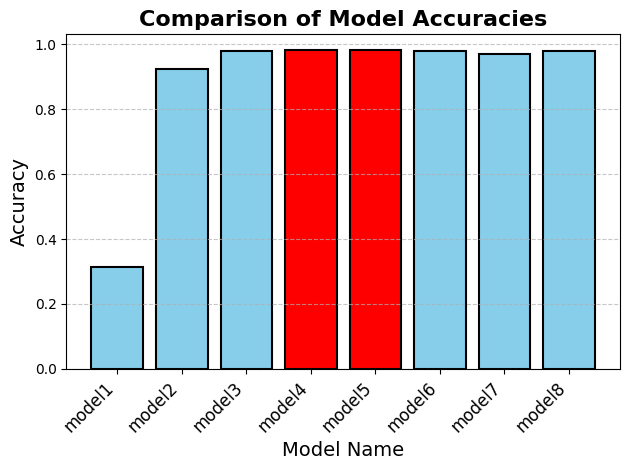

In [137]:
create_bar_chart(model_names, model_accuracies)

# Optimizers

## Optimizer

An optimizer is an algorithm or method used to adjust the parameters (weights and biases) of the model to minimize the loss function. The optimizer plays a crucial role in training the model efficiently and effectively.

### How Optimizers Work

1. **Initialize Parameters**: Start with initial values for the model parameters (often randomly).
2. **Compute Gradients**: During each iteration, compute the gradient of the loss function with respect to each parameter.
3. **Update Parameters**: Adjust the parameters in the direction that reduces the loss, based on the computed gradients and the optimizer's algorithm.
4. **Repeat**: Continue this process for a specified number of iterations (epochs) or until the loss converges to a minimum value.

### Detailed Steps in an Optimizer

1. **Forward Pass**: Compute the model’s predictions.
2. **Loss Calculation**: Calculate the loss by comparing predictions to the actual labels.
3. **Backward Pass**: Compute the gradients of the loss with respect to each parameter.
4. **Parameter Update**: Update the parameters using the optimizer's specific update rule.

## Deafualt Value

In [145]:
opt_model_names = []
opt_model_accuracies = []

In [146]:
BATCH_SIZE = 16
EPOCHS = 5
dataloader_train = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True)
dataloader_test = DataLoader(data_test, batch_size=BATCH_SIZE, shuffle=True)
dataloader_val = DataLoader(data_val, batch_size=BATCH_SIZE, shuffle=True)

## Adam  

Adam (Adaptive Moment Estimation) is a optimization algorithm. It combines the benefits of two other extensions of stochastic gradient descent: Adaptive Gradient Algorithm (AdaGrad) and Root Mean Square Propagation (RMSProp).  

**Key Features**  
Adaptive Learning, Moment Estimation

In [52]:
class Model_Adam(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
        self.loss = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=0.001)
        self.to(get_default_device())
        
    def forward(self,X):
        return self.layers(X)

    def predict(self,X):
        with torch.no_grad():
            return torch.argmax(self.forward(X),axis=-1)
            
    def fit(self,X,Y):
        self.optimizer.zero_grad()
        y_pred = self.forward(X)
        loss = self.loss(y_pred,Y)
        loss.backward()
        self.optimizer.step()
        return loss.item()

EPOCH 1: Train Loss = 0.2070, Validation Loss = 0.1264
EPOCH 2: Train Loss = 0.0835, Validation Loss = 0.1061
EPOCH 3: Train Loss = 0.0556, Validation Loss = 0.1033
EPOCH 4: Train Loss = 0.0403, Validation Loss = 0.0903
EPOCH 5: Train Loss = 0.0292, Validation Loss = 0.0950
ACCURACY: 0.981000


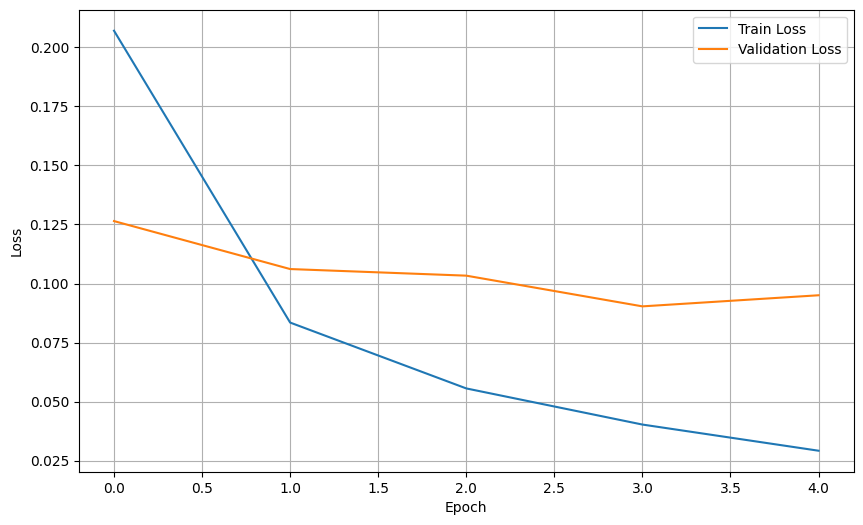

In [147]:
model_Adam = Model_Adam()
training_loss_model_Adam, val_loss_model_Adam = train_the_model(model_Adam)
acc_model_Adam = evaluate_model(model_Adam)

opt_model_names.append('Model_Adam')
opt_model_accuracies.append(acc_model_Adam)
plot_loss_curve(training_loss_model_Adam, val_loss_model_Adam)

## SGD 

Stochastic Gradient Descent (SGD) is an optimization algorithm that updates model parameters iteratively using individual training examples or small batches, allowing for faster and more frequent updates compared to batch gradient descent.

In [53]:
class Model_SGD(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
        self.loss = nn.CrossEntropyLoss()
        self.optimizer = optim.SGD(self.parameters(), lr=0.001)
        self.to(get_default_device())
        
    def forward(self,X):
        return self.layers(X)

    def predict(self,X):
        with torch.no_grad():
            return torch.argmax(self.forward(X),axis=-1)
            
    def fit(self,X,Y):
        self.optimizer.zero_grad()
        y_pred = self.forward(X)
        loss = self.loss(y_pred,Y)
        loss.backward()
        self.optimizer.step()
        return loss.item()

EPOCH 1: Train Loss = 1.8196, Validation Loss = 1.2746
EPOCH 2: Train Loss = 0.9413, Validation Loss = 0.7282
EPOCH 3: Train Loss = 0.6302, Validation Loss = 0.5587
EPOCH 4: Train Loss = 0.5139, Validation Loss = 0.4808
EPOCH 5: Train Loss = 0.4536, Validation Loss = 0.4360
ACCURACY: 0.893100


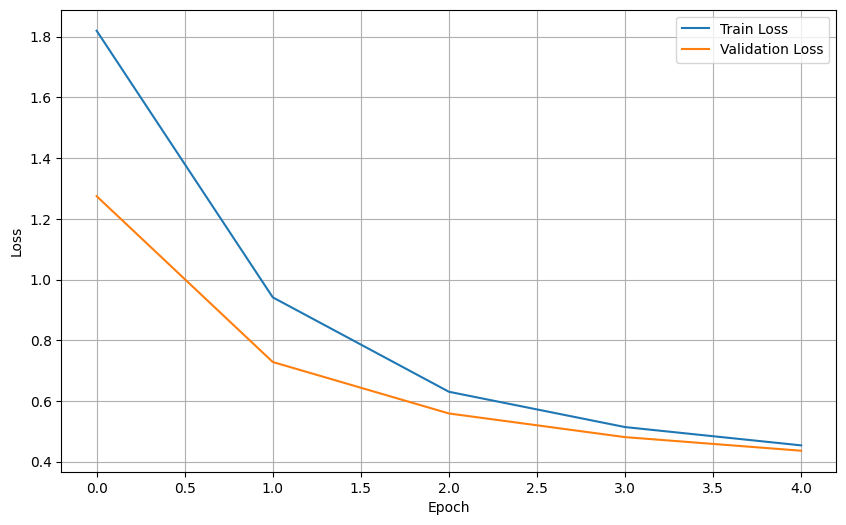

In [148]:
model_SGD = Model_SGD()
training_loss_model_SGD, val_loss_model_SGD = train_the_model(model_SGD)
acc_model_SGD = evaluate_model(model_SGD)

opt_model_names.append('Model_SGD')
opt_model_accuracies.append(acc_model_SGD)
plot_loss_curve(training_loss_model_SGD, val_loss_model_SGD)

## RMSprop  

RMSprop (Root Mean Square Propagation) is an optimization algorithm that adjusts the learning rate for each parameter by dividing the learning rate by an exponentially decaying average of squared gradients, which helps to normalize the updates and improves convergence stability.

In [55]:
class Model_RMSprop(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
        self.loss = nn.CrossEntropyLoss()
        self.optimizer = optim.RMSprop(self.parameters(), lr=0.001)
        self.to(get_default_device())
        
    def forward(self,X):
        return self.layers(X)

    def predict(self,X):
        with torch.no_grad():
            return torch.argmax(self.forward(X),axis=-1)
            
    def fit(self,X,Y):
        self.optimizer.zero_grad()
        y_pred = self.forward(X)
        loss = self.loss(y_pred,Y)
        loss.backward()
        self.optimizer.step()
        return loss.item()

EPOCH 1: Train Loss = 0.1857, Validation Loss = 0.1116
EPOCH 2: Train Loss = 0.0801, Validation Loss = 0.1068
EPOCH 3: Train Loss = 0.0545, Validation Loss = 0.1084
EPOCH 4: Train Loss = 0.0416, Validation Loss = 0.0965
EPOCH 5: Train Loss = 0.0305, Validation Loss = 0.0944
ACCURACY: 0.981300


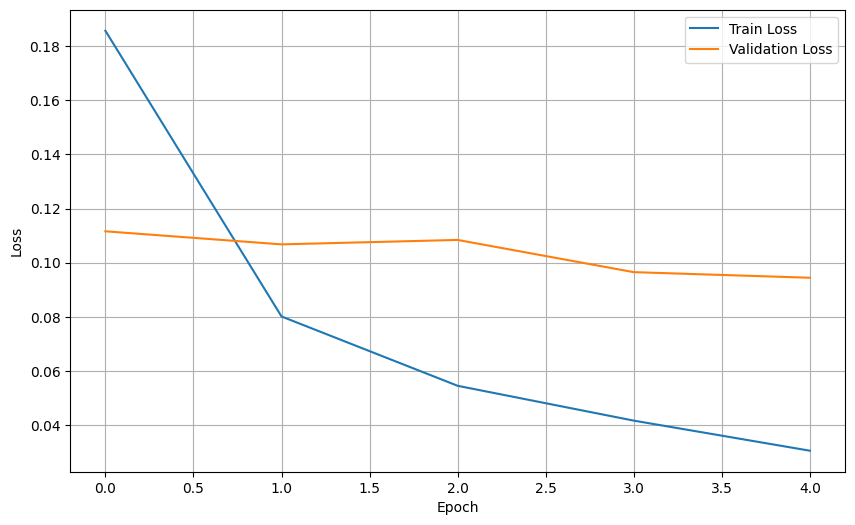

In [149]:
model_RMSprop = Model_RMSprop()
training_loss_model_RMSprop, val_loss_model_RMSprop = train_the_model(model_RMSprop)
acc_model_RMSprop = evaluate_model(model_RMSprop)

opt_model_names.append('Model_RMSprop')
opt_model_accuracies.append(acc_model_RMSprop)
plot_loss_curve(training_loss_model_RMSprop, val_loss_model_RMSprop)

## Adagrad  

Adagrad (Adaptive Gradient Algorithm) is an optimization method that adapts the learning rate for each parameter individually by dividing the learning rate by the square root of the sum of all past squared gradients, which helps to handle sparse data and improve convergence.

In [56]:
class Model_Adagrad(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
        self.loss = nn.CrossEntropyLoss()
        self.optimizer = optim.Adagrad(self.parameters(), lr=0.005)
        self.to(get_default_device())
        
    def forward(self,X):
        return self.layers(X)

    def predict(self,X):
        with torch.no_grad():
            return torch.argmax(self.forward(X),axis=-1)
            
    def fit(self,X,Y):
        self.optimizer.zero_grad()
        y_pred = self.forward(X)
        loss = self.loss(y_pred,Y)
        loss.backward()
        self.optimizer.step()
        return loss.item()

EPOCH 1: Train Loss = 0.2790, Validation Loss = 0.2077
EPOCH 2: Train Loss = 0.1744, Validation Loss = 0.1708
EPOCH 3: Train Loss = 0.1444, Validation Loss = 0.1529
EPOCH 4: Train Loss = 0.1264, Validation Loss = 0.1406
EPOCH 5: Train Loss = 0.1137, Validation Loss = 0.1324
ACCURACY: 0.966000


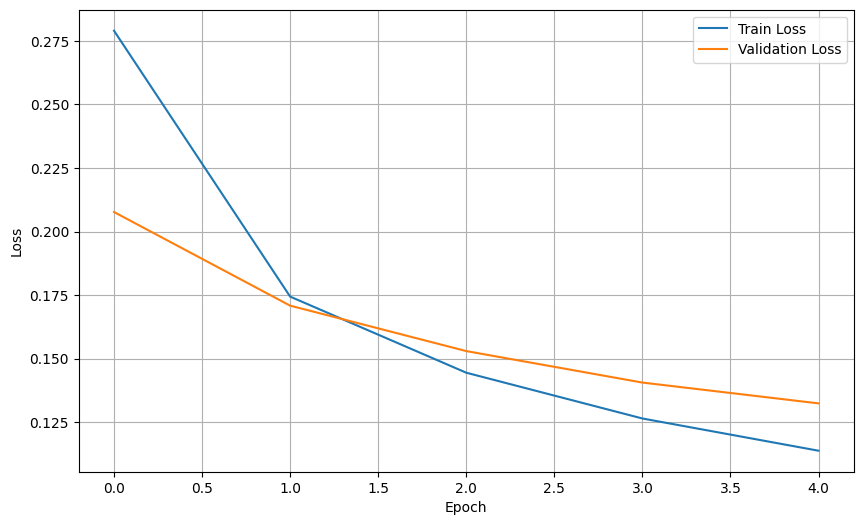

In [150]:
model_Adagrad = Model_Adagrad()
training_loss_model_Adagrad, val_loss_model_Adagrad = train_the_model(model_Adagrad)
acc_model_Adagrad = evaluate_model(model_Adagrad)

opt_model_names.append('Model_Adagrad')
opt_model_accuracies.append(acc_model_Adagrad)
plot_loss_curve(training_loss_model_Adagrad, val_loss_model_Adagrad)

## Accuracies

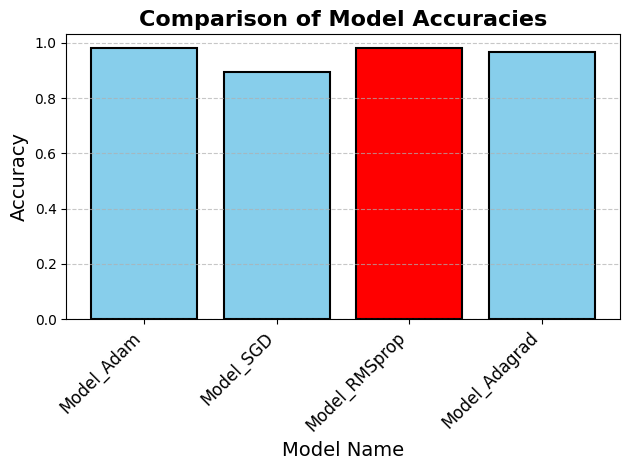

In [160]:
create_bar_chart(opt_model_names, opt_model_accuracies)

## Result

After running the models several times, optimizer Adam and RMSprop have the best accuracy and the least loss.  
I'm gonna with Adam because in most of times run models has better accuracy.

# Learning rate

## Default value

In [88]:
LR_model_names = []
LR_model_accuracies = []

In [89]:
BATCH_SIZE = 16
EPOCHS = 5
dataloader_train = DataLoader(data_train, batch_size=BATCH_SIZE ,shuffle=True)
dataloader_test = DataLoader(data_test, batch_size=BATCH_SIZE,shuffle=True)
dataloader_val = DataLoader(data_val, batch_size=BATCH_SIZE, shuffle=True)

## Model

In [87]:
class Model_Adam_LR(nn.Module):
    def __init__(self, LR=0.001):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
        self.loss = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=LR)
        self.to(get_default_device())
        
    def forward(self,X):
        return self.layers(X)

    def predict(self,X):
        with torch.no_grad():
            return torch.argmax(self.forward(X), axis=-1)
            
    def fit(self,X,Y):
        self.optimizer.zero_grad()
        y_pred = self.forward(X)
        loss = self.loss(y_pred,Y)
        loss.backward()
        self.optimizer.step()
        return loss.item()

Learning Rate: 0.0001
EPOCH 1: Train Loss = 0.4572, Validation Loss = 0.2713
EPOCH 2: Train Loss = 0.2241, Validation Loss = 0.2008
EPOCH 3: Train Loss = 0.1696, Validation Loss = 0.1629
EPOCH 4: Train Loss = 0.1347, Validation Loss = 0.1428
EPOCH 5: Train Loss = 0.1104, Validation Loss = 0.1256
ACCURACY: 0.967200


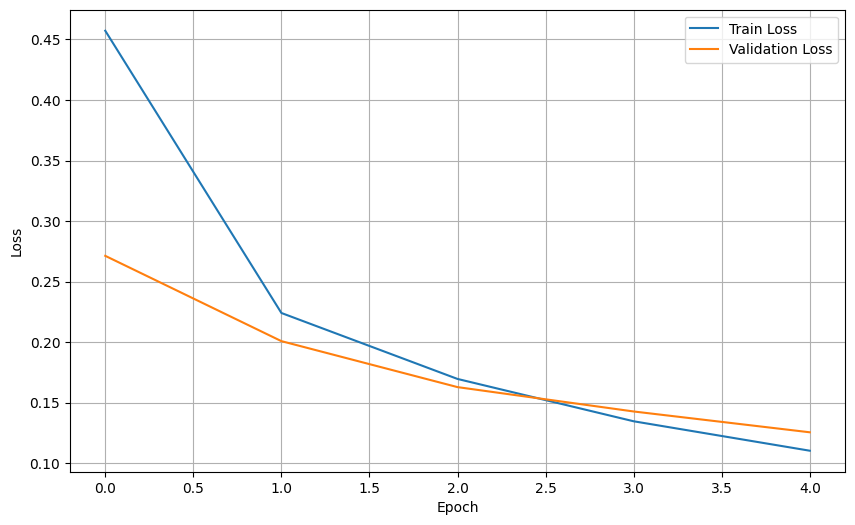


Learning Rate: 0.0005
EPOCH 1: Train Loss = 0.2539, Validation Loss = 0.1434
EPOCH 2: Train Loss = 0.1006, Validation Loss = 0.1025
EPOCH 3: Train Loss = 0.0634, Validation Loss = 0.0889
EPOCH 4: Train Loss = 0.0430, Validation Loss = 0.0872
EPOCH 5: Train Loss = 0.0312, Validation Loss = 0.0840
ACCURACY: 0.979600


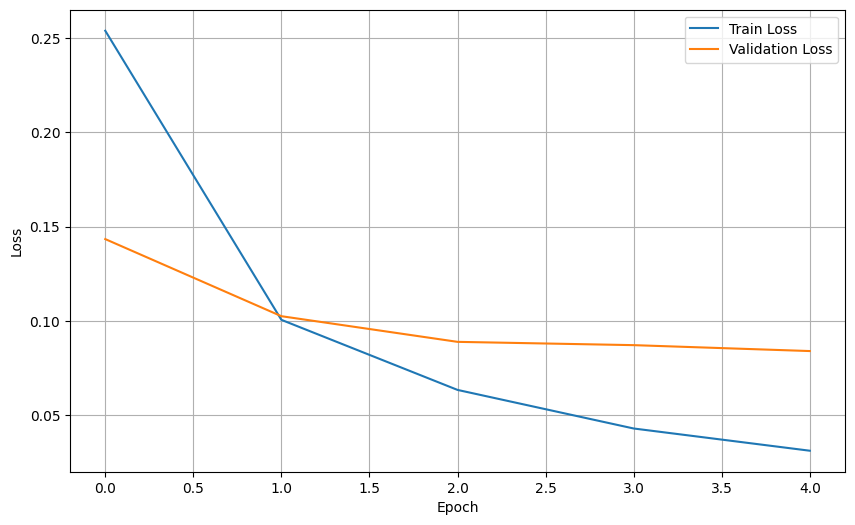


Learning Rate: 0.001
EPOCH 1: Train Loss = 0.2073, Validation Loss = 0.1232
EPOCH 2: Train Loss = 0.0838, Validation Loss = 0.1018
EPOCH 3: Train Loss = 0.0544, Validation Loss = 0.1142
EPOCH 4: Train Loss = 0.0378, Validation Loss = 0.1053
EPOCH 5: Train Loss = 0.0302, Validation Loss = 0.1064
ACCURACY: 0.979700


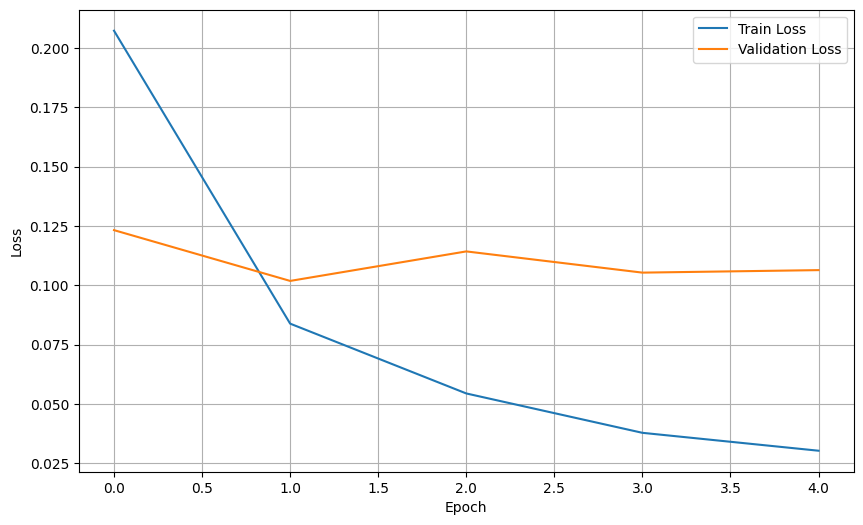


Learning Rate: 0.005
EPOCH 1: Train Loss = 0.2235, Validation Loss = 0.1686
EPOCH 2: Train Loss = 0.1365, Validation Loss = 0.1784
EPOCH 3: Train Loss = 0.1152, Validation Loss = 0.1611
EPOCH 4: Train Loss = 0.1006, Validation Loss = 0.1778
EPOCH 5: Train Loss = 0.0957, Validation Loss = 0.1588
ACCURACY: 0.968600


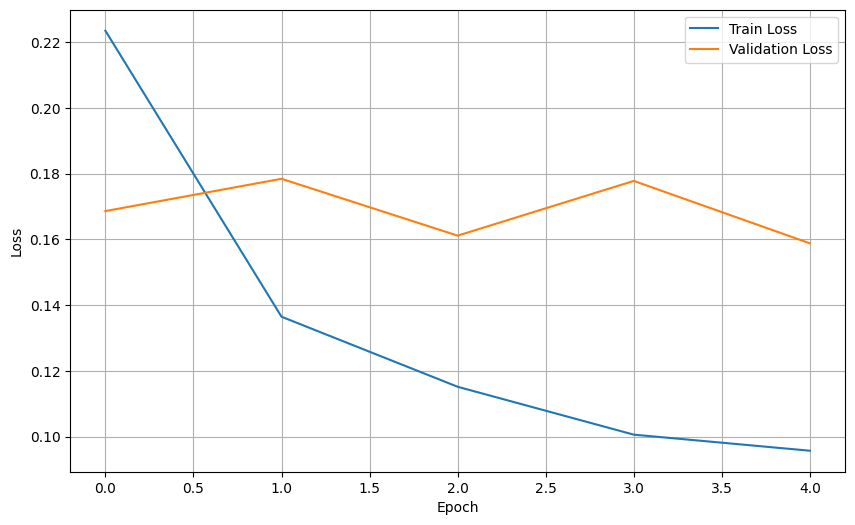


Learning Rate: 0.01
EPOCH 1: Train Loss = 0.2913, Validation Loss = 0.2501
EPOCH 2: Train Loss = 0.2116, Validation Loss = 0.2261
EPOCH 3: Train Loss = 0.1879, Validation Loss = 0.2495
EPOCH 4: Train Loss = 0.1746, Validation Loss = 0.2476
EPOCH 5: Train Loss = 0.1656, Validation Loss = 0.2419
ACCURACY: 0.954800


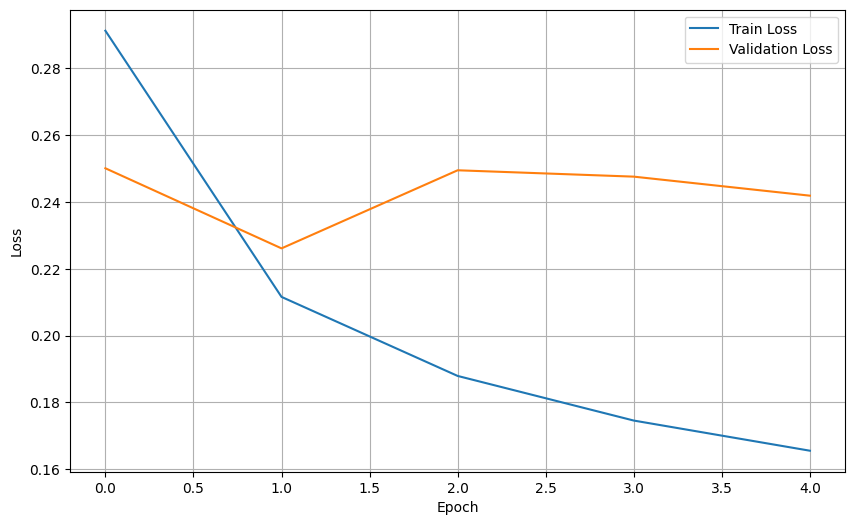


Learning Rate: 0.05
EPOCH 1: Train Loss = 0.8680, Validation Loss = 0.9751
EPOCH 2: Train Loss = 0.9058, Validation Loss = 0.9005
EPOCH 3: Train Loss = 0.8681, Validation Loss = 0.9557
EPOCH 4: Train Loss = 0.8465, Validation Loss = 0.9929
EPOCH 5: Train Loss = 0.8666, Validation Loss = 1.2885
ACCURACY: 0.790600


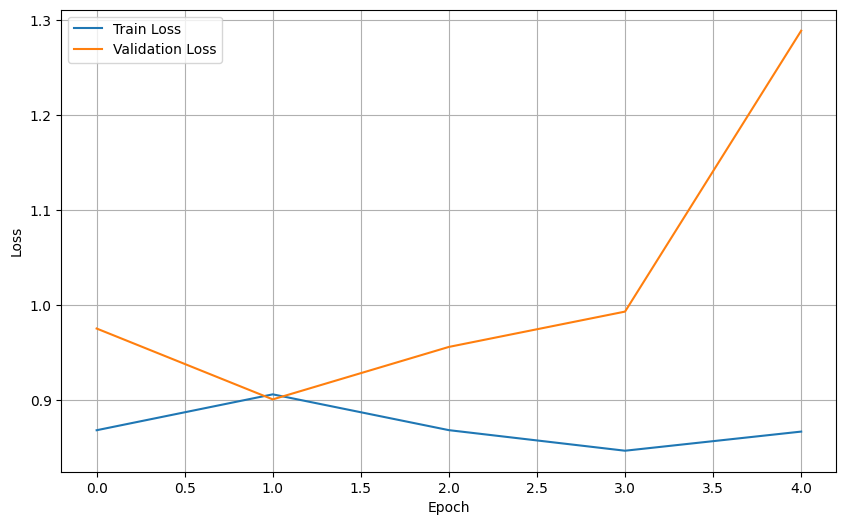


Learning Rate: 0.1
EPOCH 1: Train Loss = 1.8081, Validation Loss = 1.6422
EPOCH 2: Train Loss = 1.6962, Validation Loss = 1.8392
EPOCH 3: Train Loss = 1.6863, Validation Loss = 1.9198
EPOCH 4: Train Loss = 1.6980, Validation Loss = 1.8307
EPOCH 5: Train Loss = 1.6451, Validation Loss = 2.0478
ACCURACY: 0.412400


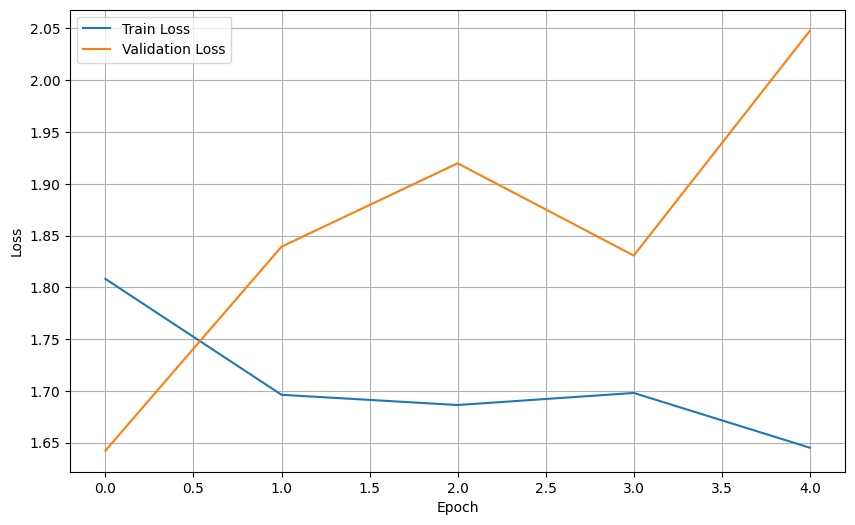


Learning Rate: 0.5
EPOCH 1: Train Loss = 6.2420, Validation Loss = 2.4235
EPOCH 2: Train Loss = 2.3996, Validation Loss = 2.3420
EPOCH 3: Train Loss = 2.3871, Validation Loss = 2.4107
EPOCH 4: Train Loss = 2.3820, Validation Loss = 2.4204
EPOCH 5: Train Loss = 2.3864, Validation Loss = 2.3600
ACCURACY: 0.103000


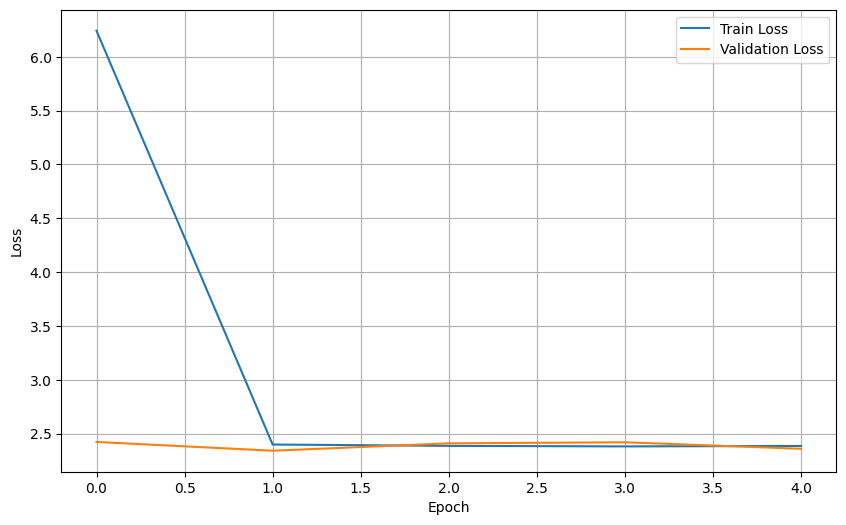

In [154]:
Learning_rates = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
for lr in Learning_rates:
    print(f'Learning Rate: {lr}')
    model_Adam_LR = Model_Adam_LR(lr)
    training_loss_model_Adam_LR, val_loss_model_Adam_LR = train_the_model(model_Adam_LR)
    acc_model_Adam_LR = evaluate_model(model_Adam_LR)

    LR_model_names.append('Adam_LR=' + str(lr))
    LR_model_accuracies.append(acc_model_Adam_LR)
    plot_loss_curve(training_loss_model_Adam_LR, val_loss_model_Adam_LR)
    print()

## Accuracies

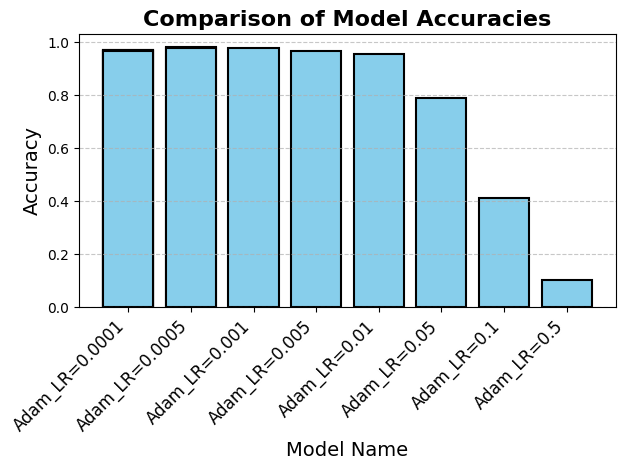

In [163]:
create_bar_chart(LR_model_names, LR_model_accuracies)

## Result

**Increasing Learning Rate:** Faster Convergence, Risk of Overshooting.  
**Decreasing Learning Rate:** Stable Convergence, Slow Convergence.  

As the learning rate increases, the accuracy decreases and the validation data loss increases, if we consider its value too low, the model training time increases.  
According to the above chart, the best learning rate value is 0.001, it has good learning time and high accuracy.

# Hyperparameter Tuning

In [181]:
class Model_HT(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
        self.loss = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters())
        self.to(get_default_device())
        
    def forward(self,X):
        return self.layers(X)

    def predict(self,X):
        with torch.no_grad():
            return torch.argmax(self.forward(X),axis=-1)
            
    def fit(self,X,Y):
        self.optimizer.zero_grad()
        y_pred = self.forward(X)
        loss = self.loss(y_pred,Y)
        loss.backward()
        self.optimizer.step()
        return loss.item()

## Batch size

In [182]:
batch_model_names = []
batch_model_accuracies = []

BATCH_SIZEs = [8, 16, 32, 64, 128]
EPOCHS = 5

Batch Size: 8
EPOCH 1: Train Loss = 0.1954, Validation Loss = 0.1333
EPOCH 2: Train Loss = 0.0833, Validation Loss = 0.0947
EPOCH 3: Train Loss = 0.0583, Validation Loss = 0.1104
EPOCH 4: Train Loss = 0.0426, Validation Loss = 0.1071
EPOCH 5: Train Loss = 0.0342, Validation Loss = 0.1076
ACCURACY: 0.979400


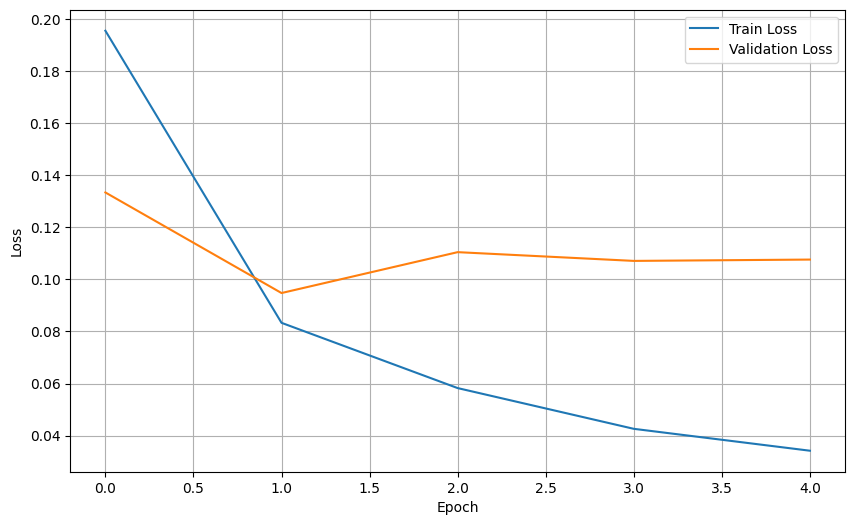


Batch Size: 16
EPOCH 1: Train Loss = 0.2042, Validation Loss = 0.1229
EPOCH 2: Train Loss = 0.0811, Validation Loss = 0.1002
EPOCH 3: Train Loss = 0.0546, Validation Loss = 0.0997
EPOCH 4: Train Loss = 0.0382, Validation Loss = 0.0997
EPOCH 5: Train Loss = 0.0284, Validation Loss = 0.1094
ACCURACY: 0.979400


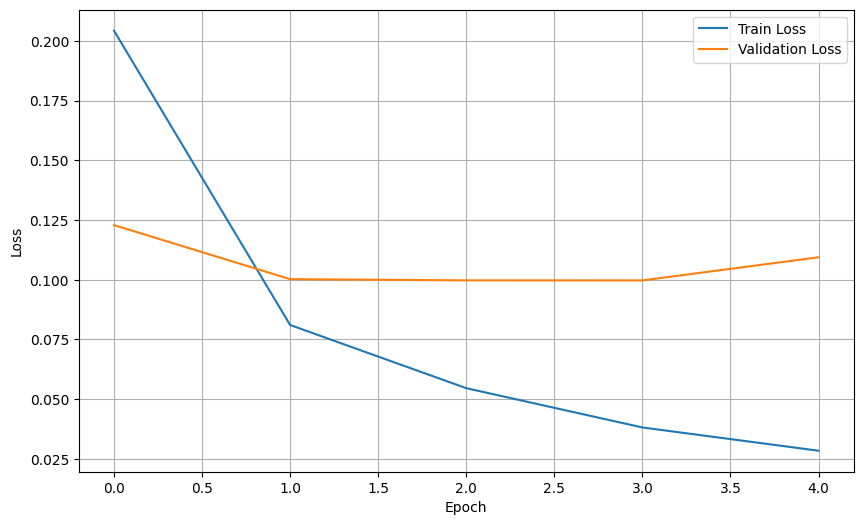


Batch Size: 32
EPOCH 1: Train Loss = 0.2337, Validation Loss = 0.1311
EPOCH 2: Train Loss = 0.0893, Validation Loss = 0.1039
EPOCH 3: Train Loss = 0.0580, Validation Loss = 0.0895
EPOCH 4: Train Loss = 0.0403, Validation Loss = 0.0933
EPOCH 5: Train Loss = 0.0297, Validation Loss = 0.1014
ACCURACY: 0.977935


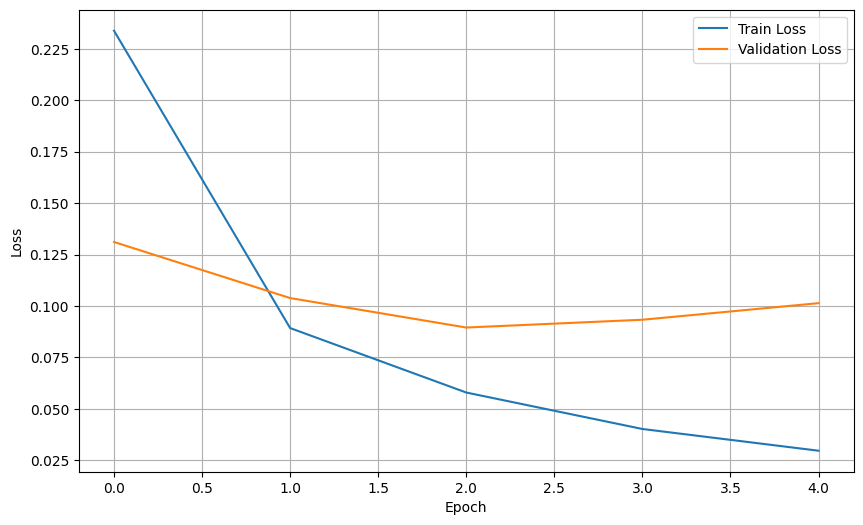


Batch Size: 64
EPOCH 1: Train Loss = 0.2744, Validation Loss = 0.1480
EPOCH 2: Train Loss = 0.1051, Validation Loss = 0.1060
EPOCH 3: Train Loss = 0.0684, Validation Loss = 0.1011
EPOCH 4: Train Loss = 0.0483, Validation Loss = 0.0930
EPOCH 5: Train Loss = 0.0333, Validation Loss = 0.0804
ACCURACY: 0.975119


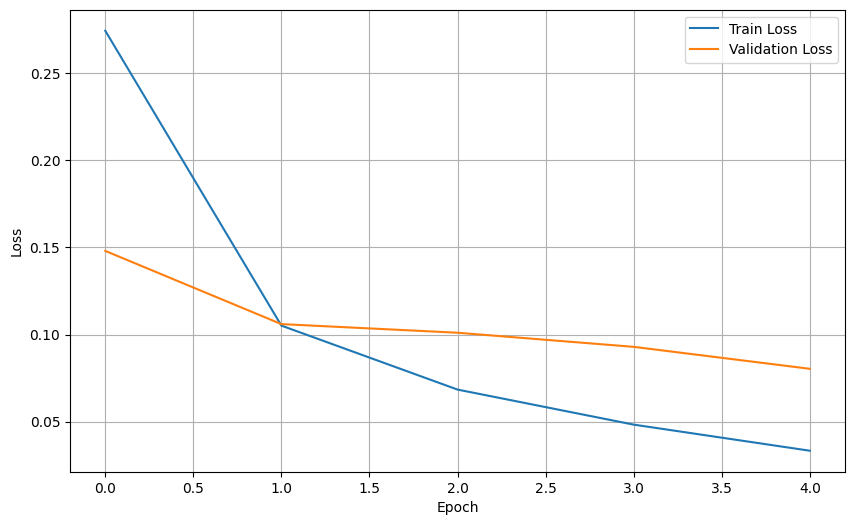


Batch Size: 128
EPOCH 1: Train Loss = 0.3351, Validation Loss = 0.1844
EPOCH 2: Train Loss = 0.1360, Validation Loss = 0.1211
EPOCH 3: Train Loss = 0.0897, Validation Loss = 0.0999
EPOCH 4: Train Loss = 0.0650, Validation Loss = 0.0901
EPOCH 5: Train Loss = 0.0465, Validation Loss = 0.0923
ACCURACY: 0.965585


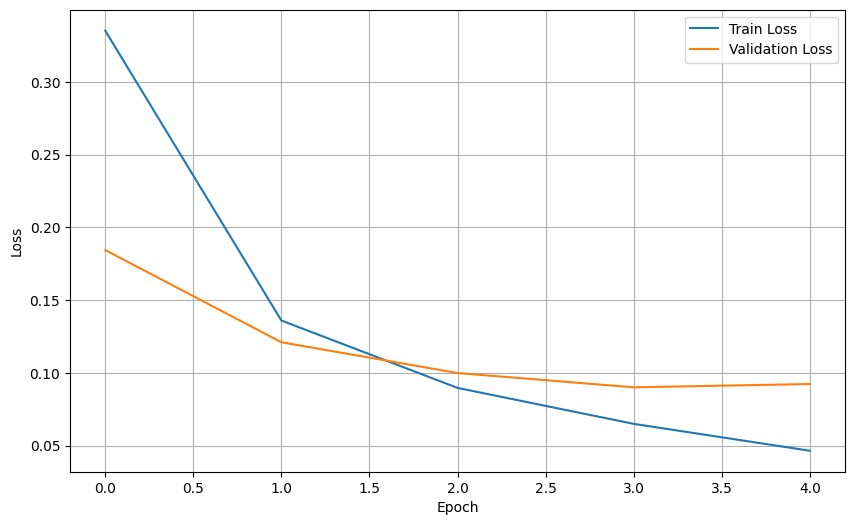

In [183]:
for batchsize in BATCH_SIZEs:
    model_batch = Model_HT()
    BATCH_SIZE = batchsize
    dataloader_train = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True)
    dataloader_test = DataLoader(data_test, batch_size=BATCH_SIZE, shuffle=True)
    dataloader_val = DataLoader(data_val, batch_size=BATCH_SIZE, shuffle=True)

    print(f'Batch Size: {batchsize}')
    training_loss_model_batch, val_loss_model_batch = train_the_model(model_batch)
    acc_model_batch = evaluate_model(model_batch)

    batch_model_names.append('Batch=' + str(batchsize))
    batch_model_accuracies.append(acc_model_batch)
    plot_loss_curve(training_loss_model_batch, val_loss_model_batch)
    print()

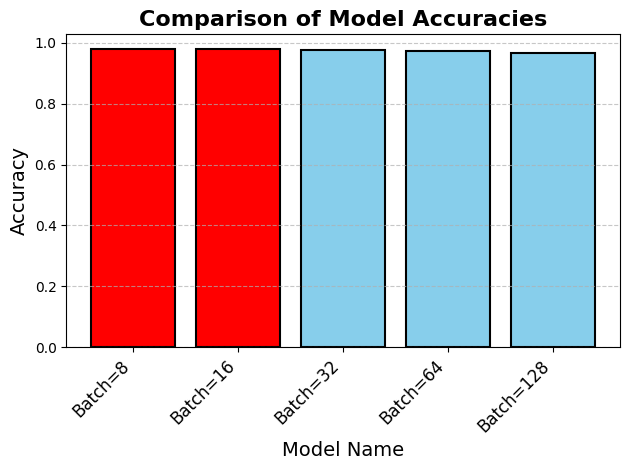

In [184]:
create_bar_chart(batch_model_names, batch_model_accuracies)

### Result  

**Increasing Batch Size:** Smoother Gradient Estimates, Better Utilization of Hardware, Higher Memory Requirement.  
**Decreasing Batch Size:** More Frequent Updates, Noisier Gradient Estimates, Lower Memory Requirement.  

As the batch increases, the amount of loss increases, and the best value for it is 16 and 32.

## Epoch

In [185]:
BATCH_SIZE = 16
EPOCHS_list = [2, 4, 5, 6, 8, 10]

epoch_model_names = []
epoch_model_accuracies = []

Epoch: 2
EPOCH 1: Train Loss = 0.2072, Validation Loss = 0.1245
EPOCH 2: Train Loss = 0.0839, Validation Loss = 0.1021
ACCURACY: 0.972800


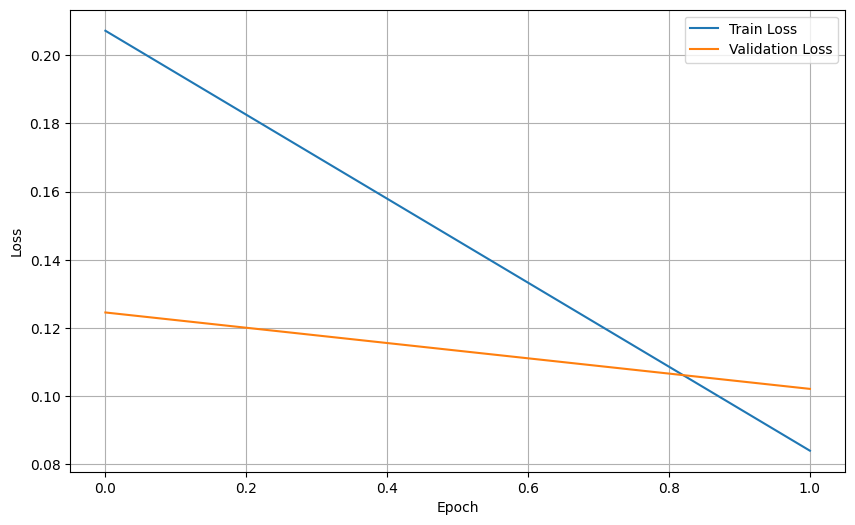


Epoch: 4
EPOCH 1: Train Loss = 0.2058, Validation Loss = 0.1198
EPOCH 2: Train Loss = 0.0834, Validation Loss = 0.1021
EPOCH 3: Train Loss = 0.0554, Validation Loss = 0.0883
EPOCH 4: Train Loss = 0.0391, Validation Loss = 0.1090
ACCURACY: 0.976200


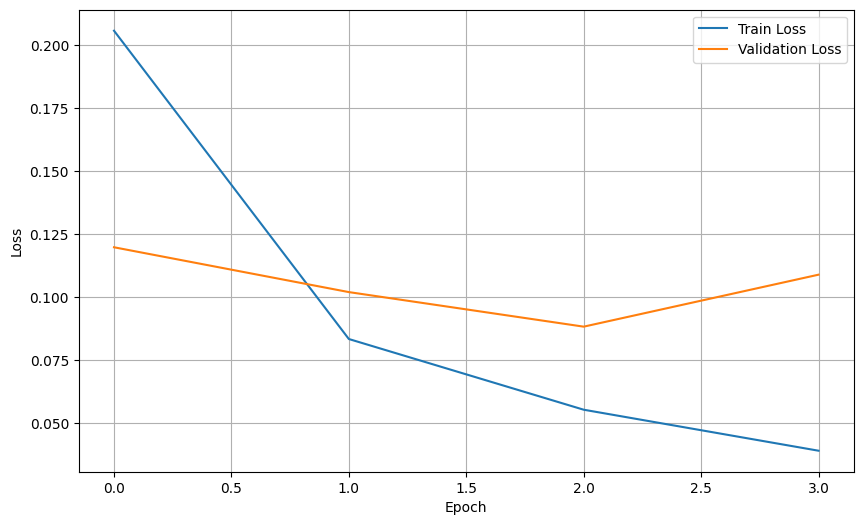


Epoch: 5
EPOCH 1: Train Loss = 0.2082, Validation Loss = 0.1175
EPOCH 2: Train Loss = 0.0826, Validation Loss = 0.1061
EPOCH 3: Train Loss = 0.0532, Validation Loss = 0.1095
EPOCH 4: Train Loss = 0.0367, Validation Loss = 0.0987
EPOCH 5: Train Loss = 0.0298, Validation Loss = 0.0914
ACCURACY: 0.980200


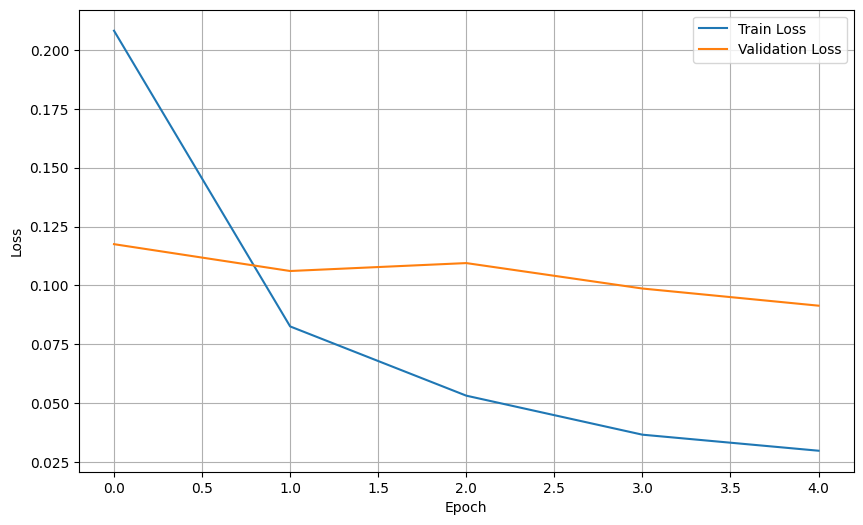


Epoch: 6
EPOCH 1: Train Loss = 0.2070, Validation Loss = 0.1119
EPOCH 2: Train Loss = 0.0815, Validation Loss = 0.0895
EPOCH 3: Train Loss = 0.0523, Validation Loss = 0.0873
EPOCH 4: Train Loss = 0.0374, Validation Loss = 0.0845
EPOCH 5: Train Loss = 0.0299, Validation Loss = 0.0916
EPOCH 6: Train Loss = 0.0228, Validation Loss = 0.1073
ACCURACY: 0.980300


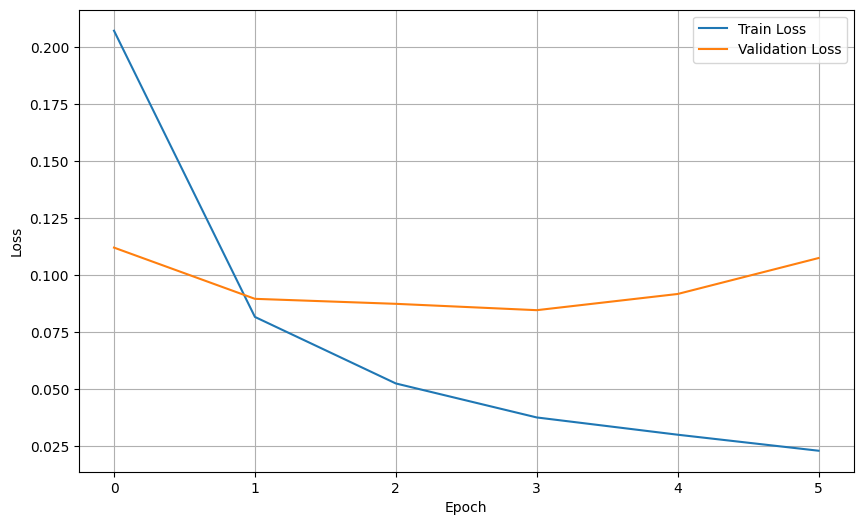


Epoch: 8
EPOCH 1: Train Loss = 0.2098, Validation Loss = 0.1207
EPOCH 2: Train Loss = 0.0828, Validation Loss = 0.0943
EPOCH 3: Train Loss = 0.0543, Validation Loss = 0.0927
EPOCH 4: Train Loss = 0.0396, Validation Loss = 0.0981
EPOCH 5: Train Loss = 0.0282, Validation Loss = 0.1027
EPOCH 6: Train Loss = 0.0233, Validation Loss = 0.0999
EPOCH 7: Train Loss = 0.0199, Validation Loss = 0.1193
EPOCH 8: Train Loss = 0.0171, Validation Loss = 0.1133
ACCURACY: 0.978500


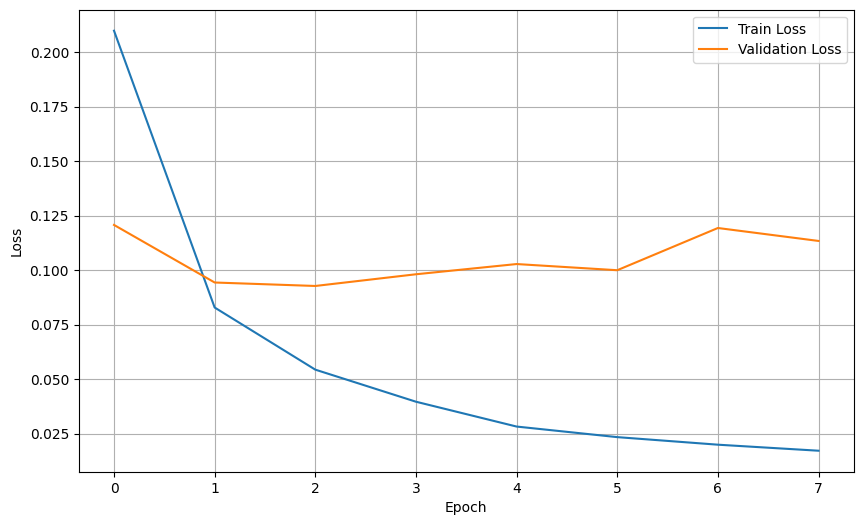


Epoch: 10
EPOCH 1: Train Loss = 0.2083, Validation Loss = 0.1241
EPOCH 2: Train Loss = 0.0828, Validation Loss = 0.1061
EPOCH 3: Train Loss = 0.0550, Validation Loss = 0.0985
EPOCH 4: Train Loss = 0.0383, Validation Loss = 0.0967
EPOCH 5: Train Loss = 0.0282, Validation Loss = 0.1256
EPOCH 6: Train Loss = 0.0233, Validation Loss = 0.1229
EPOCH 7: Train Loss = 0.0199, Validation Loss = 0.0951
EPOCH 8: Train Loss = 0.0149, Validation Loss = 0.1077
EPOCH 9: Train Loss = 0.0152, Validation Loss = 0.1134
EPOCH 10: Train Loss = 0.0138, Validation Loss = 0.1268
ACCURACY: 0.978700


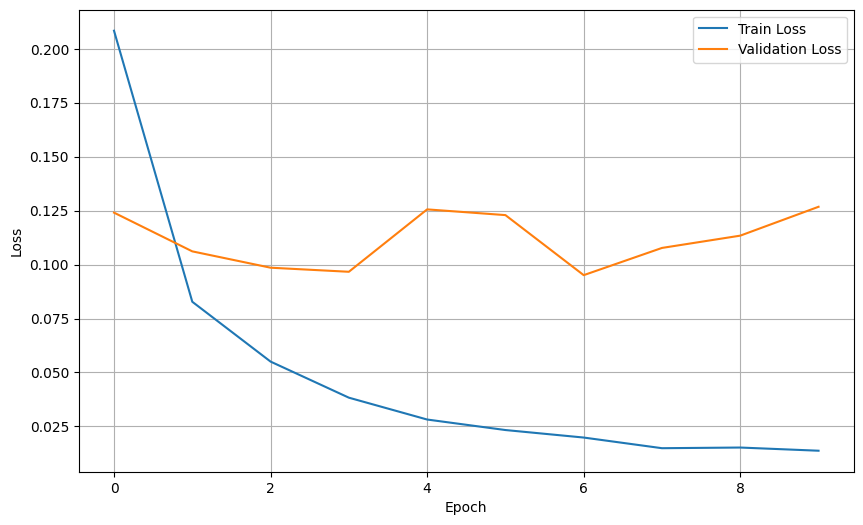

In [186]:
model_epoch = Model_HT()
for epo in EPOCHS_list:
    model_epoch = Model_HT()
    EPOCHS = epo
    dataloader_train = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True)
    dataloader_test = DataLoader(data_test, batch_size=BATCH_SIZE, shuffle=True)
    dataloader_val = DataLoader(data_val, batch_size=BATCH_SIZE, shuffle=True)

    print(f'Epoch: {epo}')
    training_loss_model_epoch, val_loss_model_epoch = train_the_model(model_epoch)
    acc_model_epoch = evaluate_model(model_epoch)

    epoch_model_names.append('Epoch=' + str(epo))
    epoch_model_accuracies.append(acc_model_epoch)
    plot_loss_curve(training_loss_model_epoch, val_loss_model_epoch)
    print()

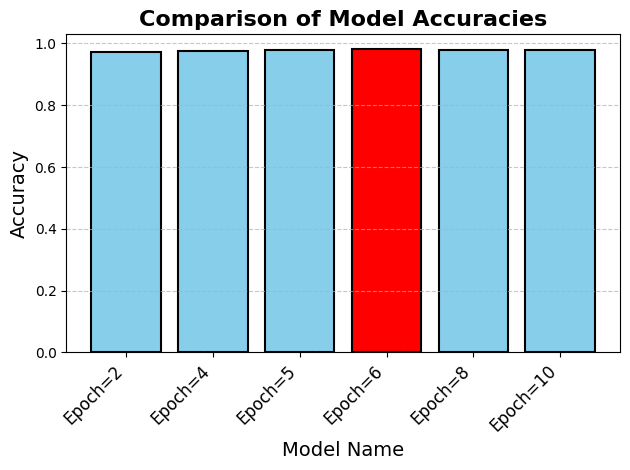

In [187]:
create_bar_chart(epoch_model_names, epoch_model_accuracies)

### Result  

According to the loss validation date diagram, the validation loss will increase in the 6th epoch and the model will be overfit.  
If we set the number of epochs to 1, the model will suffer from underfit.  

So best number of epochs is 5.  

# Activation function

# Droup out

# Batch normalization

# Resources